---
title: "DR CRC Model, DR calibration"
format: html
execute:
    echo: false
---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps #https://csaps.readthedocs.io/en/latest/
import common_functions as func
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import seaborn as sns

In [3]:
# Some aesthetic options
np.set_printoptions(suppress=True, linewidth=300, formatter={'float': '{: 0.9f}'.format})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# Global Parameters
starting_age = 20
max_age = 100
N = 100000  # Size of sample populations

# State Structure
health_states = {'healthy': 0,
                 'LR_polyp': 1,
                 'HR_polyp': 2,
                 'u_CRC_loc': 3,
                 'u_CRC_reg': 4,
                 'u_CRC_dis': 5,
                 'd_CRC_loc': 6,
                 'd_CRC_reg': 7,
                 'd_CRC_dis': 8,
                 'cancer_death': 9,
                 'healthy_ACM': 10,
                 'cancer_ACM': 11,
                 'polyp_ACM': 12,  # death while in polyp state
                 'uCRC_ACM': 13}  # death while in undiagnosed state
acm_states = [10,12,12,13,13,13,11,11,11]

# Age Groupings (len=16)
#ages = {"20-25":0, "25-29":1, "30-35":2, "35-39":3, "40-45":4, "45-49":5, "50-54":6, "55-59":7, "60-64":8, 
#        "65-69":9, "70-74":10, "75-79":11, "80-84":12, "85-89":13, "90-95":14, "95+":15}
ages = np.arange(0,80,1)
age_starts = np.arange(20,100,1)
ages = np.arange(0, len(age_starts), 1)

starting_pop = np.zeros((len(health_states),1)) # (14,1)
starting_pop[0,0]=N # Everyone starts in healthy state

### Inputs
# All cause mortality
acm_dr = pd.read_excel("data/acm_dr.xlsx", sheet_name="ACM_1Y") 
acm_rate=acm_dr['Prob'].to_numpy()[:-1]
#acm_rate=[func.probtoprob(x) for x in acm_rate]
acm_rate = np.array(list(map(func.probtoprob, acm_rate)))

# Cancer specific death 
seer_surv = pd.read_excel("data/survival_km.xlsx", sheet_name="Survival").reset_index(drop=True) # In 5y age layers
seer_surv = seer_surv[seer_surv['Age']<100]
csd_rate = seer_surv[['Local', 'Regional', 'Distant']].apply(lambda col: func.probtoprob(col)).to_numpy() # Convert to monthly probs
age_points = np.arange(20, 100, 5)  # Original age points (every 5 years)
new_age_points = np.arange(20,100,1)

csd_interp = {}
for col in ['Local', 'Regional', 'Distant']:
    f = interp1d(age_points, seer_surv[col], kind='linear', fill_value="extrapolate")
    csd_interp[col] = f(new_age_points)

csd_rate = pd.DataFrame(csd_interp).apply(lambda col: func.probtoprob(col)).to_numpy()

### Calibration Targets
# Target 1: SEER Incidence
dr_inc = pd.read_excel("data/incidence_crude.xlsx", sheet_name="1975-1990 Adj")
dr_inc = dr_inc[dr_inc['Age']>=20].reset_index() # single ages, 20-84 (65 ages)
dr_inc = dr_inc[dr_inc['Age']<=84].reset_index() # starting age 20, 65 ages
dr_inc = pd.read_excel("data/incidence_dr_globocan.xlsx", sheet_name="DR incidence factor")  # US rate by stage * DR factor (per age)
dr_inc = dr_inc.iloc[:65,:]

# Target 2: Polyp prevalence
polyp_prev = pd.read_excel("data/polyp_targets.xlsx", sheet_name="Sheet1")
polyp_targets=polyp_prev['Value'].to_numpy() # uCRC, polyp, uCRC + polyp 
dr_factor_flat = 0.416391039 

In [5]:
points = [(0,1),(1,2),(2,3),(3,4),(4,5),(3,6),(4,7),(5,8)]
constants = [(1,2),(2,3)]
deaths = [(0,10),(1,12),(2,12),(3,13),(4,13),(5,13),(6,11),(6,9),(7,9),(8,9),(7,11),(8,11),(9,9),(10,10),(11,11),(12,12),(13,13)]
selfs = [(0,0),(1,1),(2,2),(3,3),(4,4),(5,5),(6,6),(7,7),(8,8),(9,9),(10,10),(11,11),(12,12),(13,13)]
allowed = points+deaths+constants+selfs
orig_params=[0.005, 0.015, 0.05, 0.45, 0.50, 0.22, 0.60, 0.90]
orig_params=[func.probtoprob(x) for x in orig_params]
bounds = [(0.0001, 0.01), (0.01, 0.03), (0.01, 0.1), (0.35,0.55),(0.45,0.65),(0.15,0.29),(0.50,0.70),(0.80,1.0)]
bounds = [(func.probtoprob(x), func.probtoprob(y)) for (x,y) in bounds]


In [7]:
tmat_us = np.load("us_tmat.npy")

In [8]:
def row_normalize(matrix):
    for age_layer in range(matrix.shape[0]): # for every age group (len=16), access health state (14x14) matrix
        layer=matrix[age_layer]
        # Calculate the sum of non-diagonal elements for each row
        sum_of_columns = np.sum(layer, axis=1) - np.diag(layer)
        # Set the diagonal elements
        np.fill_diagonal(matrix[age_layer], 1 - sum_of_columns)
    return matrix

def constrain(matrix):
    matrix = np.clip(matrix,0.0,0.6)
    # for idx, (from_state, to_state) in enumerate(points):
    #     lower, upper = bounds[idx]
    #     matrix[:,from_state,to_state] = np.clip(matrix[:,from_state,to_state],lower,upper)

    # Progression Block
    matrix[:,0,1] = np.maximum(0.000001, matrix[:,0,1])  # not below 0
    matrix[:,0,1] = np.minimum(matrix[:,0,1], matrix[:,1,2]) 
    
    # Detection Block
    matrix[:,3,6] = np.maximum(0, matrix[:,3,6])  # not below 0
    matrix[:,4,7] = np.maximum(matrix[:,3,6], matrix[:,4,7])  # P[d_reg] > P[d_loc]
    matrix[:,5,8] = np.maximum(matrix[:,4,7], matrix[:,5,8])  # P[d_dis] > P[d_reg]
    
    return matrix

def add_csd(matrix):
    matrix[:, 6, 9] = csd_rate[:, 0]
    matrix[:, 7, 9] = csd_rate[:, 1]
    matrix[:, 8, 9] = csd_rate[:, 2]
    return matrix

def add_acm(matrix):
    matrix[:,0,10] = acm_rate  # Healthy to ACM
    matrix[:,1:3,12] = acm_rate[:, np.newaxis] # Polyp to ACM
    matrix[:,3:6,13] = acm_rate[:, np.newaxis] # Undiagnosed to ACM
    matrix[:,6:9,11] = acm_rate[:, np.newaxis]  # Cancer to ACM
    
    matrix[:,9,9] = 1  # Stay in CSD
    matrix[:,10,10] = 1  # Stay in ACM
    matrix[:,11,11] = 1  # Stay in Cancer ACM
    matrix[:,12,12] = 1  # Stay in Polyp ACM
    matrix[:,13,13] = 1  # Stay in uCRC ACM

    return matrix 


def interp_matrix(matrix):
    age_mids = new_age_points
    new_matrix = np.copy(matrix)
        
    for (from_state, to_state) in points: 
        tsmooth_spline = csaps(age_mids, matrix[:,from_state,to_state],smooth=.001)
        new_matrix[:,from_state,to_state] = tsmooth_spline(age_mids).clip(0.000001,0.6)
    
    new_matrix[:,0,1] = np.clip(new_matrix[:,0,1],0.00001, 0.001)

    return new_matrix


def run_markov(matrix, starting_age=20, max_age=100):
    current_age = starting_age
    stage = 0 
    month_pop, pop_log = starting_pop, starting_pop
    inc_log = np.zeros(pop_log.shape)  # to track new incidences in each state 
    age_layer = 0
    mat = matrix[age_layer]
    mat = mat.T
    inflow_mat = np.tril(mat, k=-1)
    while current_age < max_age:
        mat = matrix[age_layer].T
        inflow_mat = np.tril(mat, k=-1)
        # Get incidence of current month's transitions
        month_inc = np.matmul(inflow_mat, month_pop) #(14,14)(14,1)-->(14,1)
        # Actually make transitions
        month_pop = np.matmul(mat, month_pop)
        # Add to log
        inc_log = np.concatenate((inc_log, month_inc), axis=1)
        pop_log = np.concatenate((pop_log, month_pop), axis=1)
        stage += 1
        if stage % 12 == 0:
            current_age += 1
            age_layer += 1
            
    inc_log = inc_log[:, 1:] # make (14,960)
    inc_rate = inc_log.copy() # make (14,960)
    pop_log = pop_log[:, 1:] # make (14,960)
    
    dead_factor = np.divide(N, N-pop_log[9:,:].sum(axis=0)) # inc and prev denominator is out of living only
    prevalence = np.zeros(pop_log.shape) #(14,80)
    
    for state in range(14):
        inc_rate[state,:] = np.multiply(inc_rate[state,:], dead_factor) 
        prevalence[state,:] = np.multiply(pop_log[state,:], dead_factor)

    inc_rate = inc_rate.reshape(len(health_states),80,12).sum(axis=2) # getting annual incidence (rate per 100k)
    inc_log = inc_log.reshape(len(health_states),80,12).sum(axis=2) # getting inc unadjusted
    prevalence = prevalence.reshape(len(health_states),80,12).mean(axis=2) #getting mean annual prevalence

    return inc_rate, prevalence, pop_log, inc_log

def objective(matrix, log, i):
    inc, _, _, inc_log = log
    score = 0
    
    # Primary goal: total yearly incidence
    target_inc = dr_inc['Local Rate'] + dr_inc['Regional Rate'] + dr_inc['Distant Rate']
    model_inc = inc[6,:65] + inc[7,:65] + inc[8,:65]
    np.where(model_inc<=0, model_inc, 1)
    score += np.square(model_inc-target_inc).sum() * 10
    
    # Secondary: stage distribution L/R/D
    target_ploc , target_preg, target_pdis = [35]*65, [25]*65, [40]*65
    model_ploc = inc[6,:65]/model_inc *100
    model_preg = inc[7,:65]/model_inc *100
    model_pdis = inc[8,:65]/model_inc *100
    score += np.square(model_ploc-target_ploc).sum()
    score += np.square(model_preg-target_preg).sum()
    score += np.square(model_pdis-target_pdis).sum()

    # Teritary: Polyp prevalence penalty (pooled)
    score += (1/np.sqrt(35656))*np.square(inc_log[12,:].sum() - dr_factor_flat*N*polyp_targets[1]) # polyps
    score += (1/np.sqrt(31434))*np.square(inc_log[13,:].sum() - dr_factor_flat*N*polyp_targets[0]) # uCRC

    # Plateau after age 80
    post_80_inc = model_inc[60:] 
    score += np.sum(np.square(np.diff(post_80_inc))) * 10

    # Healthy to LR
    healthy_lr_penalty = np.sum(np.square(1000*np.diff(matrix[60:,0,1])))*10 + np.sum(np.square(1000*np.diff(matrix[:10,0,1])))*10
    score += healthy_lr_penalty
    increase_penalty = np.sum(np.square(1000*np.minimum(np.diff(matrix[10:60, 0, 1]), 0)))
    score+= increase_penalty
    # Constants penalty
    score += np.square(1000*(matrix[:,2,3]-tmat_us[:,2,3])).sum() * 10
    score += np.square(100*(matrix[:,1,2]-tmat_us[:,1,2])).sum() * 10

    return score

def step(matrix, step_size, j, num_adj=7): 
    new_matrix=np.copy(matrix)
    age_layers = np.random.randint(len(ages), size=num_adj)
    cells = np.random.choice(len(points), size=num_adj, replace=True)
    for i in range(num_adj):
        new_matrix[age_layers[i], points[cells[i]][0], points[cells[i]][1]] += np.random.uniform(low=-step_size, high=step_size)
    
    new_matrix = interp_matrix(new_matrix)
    new_matrix = add_acm(new_matrix)
    new_matrix = add_csd(new_matrix)
    new_matrix = constrain(new_matrix)
    new_matrix = row_normalize(new_matrix)
    return new_matrix
def simulated_annealing(n_iterations, step_size, start_tmat=None, n_adj=7, verbose=False):
    if start_tmat is None:
        raise ValueError("Need tmat")
    else:
        best_tmat = np.copy(start_tmat)
    best_log = run_markov(best_tmat)
    best_eval = objective(best_tmat, best_log,1)  # evaluate the initial point
    curr_tmat, curr_eval = best_tmat, best_eval  # current working solution
    
    for i in range(n_iterations):  
        # Create candidate tmat by taking step
        candidate_tmat = step(curr_tmat, step_size, i, n_adj)


        # Evaluate the candidate transition matrix
        candidate_log = run_markov(candidate_tmat)
        candidate_eval = objective(candidate_tmat, candidate_log,i)  # Evaluate candidate point
        
        # Update "best" if better than candidate
        if candidate_eval < best_eval:
            best_tmat, best_eval = np.copy(candidate_tmat), candidate_eval
            best_log = run_markov(best_tmat)
        
        # Calculate temp for current epoch
        # t = 10 / float(i+1)  
        t = 1 /(1+np.log(i+1))
        
        # Progress report
        if verbose and (i<22 or i%100==0):
            inc_log=best_log[3]
            total_dxd=np.sum(inc_log[6:9,:])/N 
            print(f"{i}: {best_eval}   CRC: {round(total_dxd, 5)}")

        # Check if we should update "curr"
        diff = candidate_eval - curr_eval  # difference between candidate and current point evaluation
        metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion

        # Check if we should keep the new candidate (update "curr")
        if diff < 0 or np.random.random() < metropolis:  # check if we should keep the new point
            curr_tmat, curr_eval = np.copy(candidate_tmat), candidate_eval  # store the new current point
            if diff >=0: print("selected randomly")
      
    print("---------------------------")
    print("Best eval: ", best_eval)

    return best_tmat

In [9]:
result = simulated_annealing(50000, step_size=0.01, start_tmat=tmat_us, n_adj=5, verbose=True)
#result = simulated_annealing(10000, step_size=0.005, start_tmat=result, n_adj=5, verbose=True)

0: 8344596.084461912   CRC: 0.05177
1: 8344596.084461912   CRC: 0.05177
2: 2198649.6119726566   CRC: 0.03752
3: 1999141.3107337987   CRC: 0.03697
4: 1953711.4974167855   CRC: 0.0375


C:\Users\sophi\AppData\Local\Temp\ipykernel_6524\3284567746.py:188: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion


5: 285447.3004603553   CRC: 0.01756
6: 285447.3004603553   CRC: 0.01756
7: 285447.3004603553   CRC: 0.01756
8: 271025.01668166125   CRC: 0.01693
9: 250862.5075415429   CRC: 0.01701
10: 216407.4625698481   CRC: 0.017
11: 205290.69842841002   CRC: 0.01702
12: 205290.69842841002   CRC: 0.01702
13: 205290.69842841002   CRC: 0.01702
14: 197960.41599171027   CRC: 0.01709
15: 133734.97146242246   CRC: 0.01794
16: 133734.97146242246   CRC: 0.01794
17: 133734.97146242246   CRC: 0.01794
18: 133734.97146242246   CRC: 0.01794
19: 133734.97146242246   CRC: 0.01794
20: 133734.97146242246   CRC: 0.01794
21: 133734.97146242246   CRC: 0.01794
100: 34972.01400711564   CRC: 0.02059
200: 33157.92136301414   CRC: 0.02071
300: 32157.665920508574   CRC: 0.02054
400: 32157.665920508574   CRC: 0.02054
500: 31815.10854037872   CRC: 0.02055
600: 31638.14484096856   CRC: 0.0205
selected randomly
700: 30900.59639314237   CRC: 0.02061
800: 30518.86561247126   CRC: 0.02069
900: 30241.93564827189   CRC: 0.02102
1000:

ValueError: too many values to unpack (expected 2)

In [191]:
curr_tmat = result.copy()
curr_log = run_markov(curr_tmat)

In [195]:
# Function to extract transition probabilities
def extract_transition_probs(tmat, states, transitions):
    transition_probs = {}
    for from_state, to_state in transitions:
        from_idx = states[from_state]
        to_idx = states[to_state]
        params = tmat[:, from_idx, to_idx]
        transition_probs[f"{from_state} to {to_state}"] = params
    return transition_probs

# Print the transition probabilities in a readable format
def print_trans_probs(transition_probs):
    print("Monthly transition probs")
    for transition, prob in transition_probs.items():
        print(f"{transition}: {prob[30]:.5f}")

    print("\nAnnual transition probs")
    for transition, prob in transition_probs.items():
        annual_prob = func.probtoprob(prob[30], 12, 1)
        print(f"{transition}: {annual_prob:.5f}")

desired_transitions = [
    ('healthy', 'LR_polyp'),
    ('LR_polyp', 'HR_polyp'),
    ('HR_polyp', 'u_CRC_loc'),
    ('u_CRC_loc', 'u_CRC_reg'),
    ('u_CRC_reg', 'u_CRC_dis'),
    ('u_CRC_loc', 'd_CRC_loc'),
    ('u_CRC_reg', 'd_CRC_reg'),
    ('u_CRC_dis', 'd_CRC_dis')
]

transition_probs = extract_transition_probs(curr_tmat, health_states, desired_transitions)
print_trans_probs(transition_probs)

Monthly transition probs
healthy to LR_polyp: 0.00015
LR_polyp to HR_polyp: 0.00125
HR_polyp to u_CRC_loc: 0.00292
u_CRC_loc to u_CRC_reg: 0.04318
u_CRC_reg to u_CRC_dis: 0.05580
u_CRC_loc to d_CRC_loc: 0.02172
u_CRC_reg to d_CRC_reg: 0.07709
u_CRC_dis to d_CRC_dis: 0.17117

Annual transition probs
healthy to LR_polyp: 0.00185
LR_polyp to HR_polyp: 0.01485
HR_polyp to u_CRC_loc: 0.03445
u_CRC_loc to u_CRC_reg: 0.41121
u_CRC_reg to u_CRC_dis: 0.49793
u_CRC_loc to d_CRC_loc: 0.23162
u_CRC_reg to d_CRC_reg: 0.61811
u_CRC_dis to d_CRC_dis: 0.89491


### Plot transition probabilities

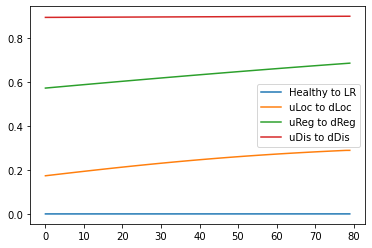

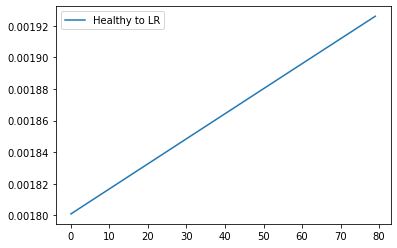

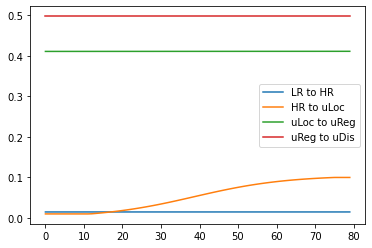

In [196]:
def plot_tps(curr_tmat):
    plt.plot(func.probtoprob(curr_tmat[:,0,1],12,1), label = "Healthy to LR")
    plt.plot(func.probtoprob(curr_tmat[:,3,6],12,1), label = "uLoc to dLoc")
    plt.plot(func.probtoprob(curr_tmat[:,4,7],12,1), label = "uReg to dReg")
    plt.plot(func.probtoprob(curr_tmat[:,5,8],12,1), label = "uDis to dDis")
    plt.legend()
    plt.show()

    plt.plot(func.probtoprob(curr_tmat[:,0,1],12,1), label = "Healthy to LR")
    plt.legend()
    plt.show()

    plt.plot(func.probtoprob(curr_tmat[:,1,2],12,1), label = "LR to HR")
    plt.plot(func.probtoprob(curr_tmat[:,2,3],12,1), label = "HR to uLoc")
    plt.plot(func.probtoprob(curr_tmat[:,3,4],12,1), label = "uLoc to uReg")
    plt.plot(func.probtoprob(curr_tmat[:,4,5],12,1), label = "uReg to uDis")
    plt.legend()
    plt.show()

plot_tps(curr_tmat)

### Plot incidence

In [ ]:
target_inc = dr_inc['Local Rate'] + dr_inc['Regional Rate'] + dr_inc['Distant Rate']

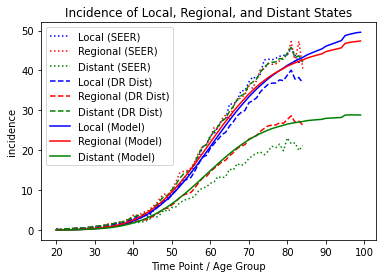

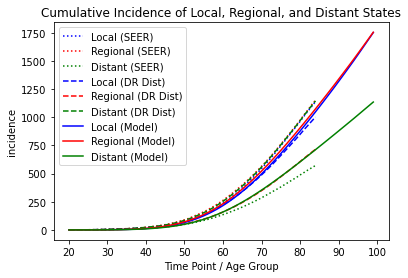

In [202]:
### Plotting
def plot_vs_dr(curr_log):
    inc_adj, _,_,_ = curr_log
    x_values = np.linspace(20,99,80)

    plt.plot(dr_inc['Age'], dr_inc['Local Rate'], label = 'Local (SEER)', color='b',linestyle="dotted")
    plt.plot(dr_inc['Age'], dr_inc['Regional Rate'], label = 'Regional (SEER)', color='r', linestyle="dotted")
    plt.plot(dr_inc['Age'], dr_inc['Distant Rate'],  label='Distant (SEER)', color='g',linestyle="dotted")
    plt.plot(dr_inc['Age'], 0.35*target_inc, label='Local (DR Dist)', color='b',linestyle="dashed")
    plt.plot(dr_inc['Age'], 0.25*target_inc,  label='Regional (DR Dist)', color='r',linestyle="dashed")
    plt.plot(dr_inc['Age'],  0.40*target_inc,  label='Distant (DR Dist)', color='g',linestyle="dashed")
    plt.plot(x_values, inc_adj[6,:], label='Local (Model)', color='b')
    plt.plot(x_values, inc_adj[7,:],  label='Regional (Model)', color='r')
    plt.plot(x_values,  inc_adj[8,:],  label='Distant (Model)', color='g')
    plt.legend()
    plt.title('Incidence of Local, Regional, and Distant States')
    plt.xlabel('Time Point / Age Group')
    plt.ylabel('incidence')
    plt.show()



    plt.plot(dr_inc['Age'], dr_inc['Local Rate'].cumsum(), label = 'Local (SEER)', color='b',linestyle="dotted")
    plt.plot(dr_inc['Age'], dr_inc['Regional Rate'].cumsum(), label = 'Regional (SEER)', color='r',linestyle="dotted")
    plt.plot(dr_inc['Age'], dr_inc['Distant Rate'].cumsum(), label = 'Distant (SEER)', color='g',linestyle="dotted")
    plt.plot(dr_inc['Age'], 0.35*target_inc.cumsum(), label='Local (DR Dist)', color='b',linestyle="dashed")
    plt.plot(dr_inc['Age'], 0.25*target_inc.cumsum(),  label='Regional (DR Dist)', color='r',linestyle="dashed")
    plt.plot(dr_inc['Age'],  0.40*target_inc.cumsum(),  label='Distant (DR Dist)', color='g',linestyle="dashed")
    plt.plot(x_values, inc_adj[6,:].cumsum(), label='Local (Model)', color='b')
    plt.plot(x_values, inc_adj[7,:].cumsum(), label='Regional (Model)', color='r')
    plt.plot(x_values, inc_adj[8,:].cumsum(), label='Distant (Model)', color='g')
    plt.legend()
    plt.title('Cumulative Incidence of Local, Regional, and Distant States')
    plt.xlabel('Time Point / Age Group')
    plt.ylabel('incidence')
    plt.show()

plot_vs_dr(curr_log)

### Plot prevalences